Imports:

In [2]:
import os
import time
import json

import numpy as np
import pandas as pd
import torch

from dotenv import load_dotenv
from openai import OpenAI
from openai._exceptions import OpenAIError, RateLimitError
from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification

import faiss

from sentence_transformers import SentenceTransformer, util

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed

c:\Users\Max\Desktop\TREC2025\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create dataFrame for the question assessment

In [3]:
# Specify the path to the text file
file_path = '2024-question-assessment.txt'

array = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.split("\t")
        if (line[5] == "4" or line[5] == "3" or line[5] == "1"):
            array.append(line)
            
dataFrame = pd.DataFrame(array)
dataFrame.columns = ["AID", "Article", "RID", "Model", "Order", "Assessment", "Useless", "Question"]
dataFrame.drop(columns=["AID", "Model", "RID", "Useless", "Order"], inplace=True)

dataFrame.head()

,Article,Assessment,Question
0,clueweb22-en0030-87-05450,1,"Who is Helen Russell, the author of the articl..."
1,clueweb22-en0030-87-05450,1,Has the show John Dillermand received support ...
2,clueweb22-en0030-87-05450,1,What is the professional credentials of Christ...
3,clueweb22-en0030-87-05450,1,"Who is Erla Heinesen Højsted, cited in the art..."
4,clueweb22-en0030-87-05450,1,Does The Guardian clearly described how the sh...


Prompt for labeling our data into categories, outputs as an csv file named output.csv

In [24]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Adjust with your data loading method
qArray = [row[7] for row in array]

categories = [
    "Author Bias",
    "Claim Verification",
    "Source Background & Credibility",
    "Publication Reputation",
    "Public Reaction",
    "Bad Question"
]

def format_prompt(qs):
    header = (
        f"Classify each of the following questions into one of these categories per line: {', '.join(categories)}.\n\n"
        "These are the criteria for a bad question:\n"
        "- The question assumes prior knowledge of the article or refers vaguely to \"the claim,\" \"the event,\" or \"this person\" without explanation.\n"
        "- If the question contains \"in the article\" it is a bad question.\n"
        "- The question can’t be answered from a single source or needs synthesis from multiple unrelated documents.\n"
        "- The question contains multiple parts, asks more than one thing at once, or is vague in its focus.\n"
        "- The question asks for interpretations, motivations, or hypothetical outcomes instead of concrete, verifiable facts."
        '\nReturn the result as plain CSV with no extra text.'
        ' Format like this:\n\n'
        '"Example question here?","Author Bias"\n'
    )
    body = "\n".join([f"\"{q.strip()}\"" for q in qs])
    return header + body

def process_batch(index, chunk, retries=3):
    prompt = format_prompt(chunk)
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
                max_tokens=4096,
            )
            return index, response.choices[0].message.content.strip().splitlines()
        except (OpenAIError, RateLimitError) as e:
            wait = 2 ** attempt
            time.sleep(wait)
    return index, []

batch_size = 50
batches = [(i, qArray[i:i + batch_size]) for i in range(0, len(qArray), batch_size)]

results = {}
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(process_batch, i, chunk) for i, chunk in batches]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        idx, lines = future.result()
        if lines:
            results[idx] = lines
        else:
            print(f"Batch {idx // batch_size} failed.")

# Sort results by original batch order
ordered = []
for i in sorted(results):
    ordered.extend(results[i])

print(f"✅ Total processed: {len(ordered)}")

# Save to CSV
with open("output.csv", "w", encoding="utf-8") as f:
    f.write('"question","category"\n')
    for line in ordered:
        if "," in line:
            f.write(line.strip() + "\n")

Processing:  47%|████▋     | 53/113 [02:51<04:12,  4.20s/it]

Batch 53 failed.


Processing:  85%|████████▍ | 96/113 [05:44<01:03,  3.75s/it]

Batch 95 failed.


Processing:  89%|████████▉ | 101/113 [06:04<00:47,  3.96s/it]

Batch 100 failed.


Processing: 100%|██████████| 113/113 [06:49<00:00,  3.62s/it]

✅ Total processed: 5698


Split Data into train/test split

In [6]:
def splitData(Question, Category):
    Q_train, Q_test, c_train, c_test = train_test_split(Question, Category, test_size=0.3, random_state=42)
    return Q_train, Q_test, c_train, c_test

Load all data into train_test_split and add it to a BERT readable dataset

In [14]:
df1 = pd.read_csv("output.csv", header=None, names=["Question", "Category"])

col1 = df1.iloc[:, 0].to_numpy()
col2 = df1.iloc[:, 1].to_numpy()

Q_train, Q_test, c_train, c_test = splitData(col1, col2)

# Load tokenizer and model with built-in classification head
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

le = LabelEncoder()
# Define custom Dataset class
class TextDataset(Dataset):
    def __init__(self, Q_train, c_train):
        self.encodings = tokenizer(Q_train, truncation=True, padding=True, return_tensors="pt")
        c_train_encoded = le.fit_transform(c_train)
        self.labels = torch.tensor(c_train_encoded)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Prepare dataset
dataset = TextDataset(list(Q_train), list(c_train))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defines hyperparameters for the model and trains it.

In [15]:
# Define training arguments
training_args = TrainingArguments(
    num_train_epochs=3,
    auto_find_batch_size = True,
    save_strategy="no"
)

# Set up Trainer API to handle training loop
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("fine_tuned_model")

Step,Training Loss
500,0.881000
1000,0.498800


Train BERT using KFOLD validation

In [ ]:
# Load data
df1 = pd.read_csv("output.csv", header=None, names=["Question", "Category"])
col1 = df1.iloc[:, 0].to_numpy()
col2 = df1.iloc[:, 1].to_numpy()
# Initialize label encoder and tokenizer
le = LabelEncoder()
le.fit(col2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Change to your model if needed
# Custom Dataset
class TextDataset(Dataset):
    def _init_(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
        self.labels = torch.tensor(le.transform(labels))
    def _len_(self):
        return len(self.labels)
    def _getitem_(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
for fold, (train_indices, val_indices) in enumerate(skf.split(col1, col2)):
    print(f"\nTraining Fold {fold+1}/5")
    # Convert from NumPy array to list[str]
    train_texts = col1[train_indices].tolist()
    train_labels = col2[train_indices].tolist()
    val_texts = col1[val_indices].tolist()
    val_labels = col2[val_indices].tolist()
    # Prepare datasets
    train_dataset = TextDataset(train_texts, train_labels)
    val_dataset = TextDataset(val_texts, val_labels)
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    # Reinitialize model per fold
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Training loop
    model.train()
    for epoch in range(3):  # Adjust as needed
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    # Evaluation loop
    model.eval()
    val_predictions = []
    val_labels_encoded = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, dim=1)
            val_predictions.extend(predicted.cpu().numpy())
            val_labels_encoded.extend(labels.cpu().numpy())
    # Decode labels
    predicted_labels = le.inverse_transform(val_predictions)
    real_labels = le.inverse_transform(val_labels_encoded)
    # Report accuracy
    accuracy = accuracy_score(val_labels_encoded, val_predictions)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(real_labels, predicted_labels))
# Average score
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy:.4f}")

Load trained model from disk

In [16]:
model = BertForSequenceClassification.from_pretrained("./fine_tuned_model")

Function for making predictions with BERT

In [ ]:
def predict(Test_Questions: list, batch_size: int):
    predictions = []
    for i in tqdm(range(0, len(Test_Questions), batch_size), desc="Running inference"):
        batch = Test_Questions[i:i+batch_size]
        test_encodings = tokenizer(batch, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**test_encodings)
            batch_preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(batch_preds)

    # Convert predicted tensor to list of integers
    predicted_labels = [label.item() for label in predictions]

    predicted_labels = le.inverse_transform(predicted_labels)

    # Print results
    for i in range(len(Test_Questions)):
        print(Test_Questions[i] + "----->" + predicted_labels[i])
    return predictions

Define input test questions for predicting

In [18]:
Q_test_list = Q_test.astype(str).tolist()  # Tune this based on your RAM
test_data = [
    # Author Bias
    "Does the article favor Ukraine's perspective in its reporting on the drone strike?",
    "Are Russian sources or officials quoted to balance the Ukrainian claims in the article?",
    "Is emotionally charged language used to describe Ukraine’s attack on Russian bombers?",
    "Does the article present Russia’s version of events with equal weight as Ukraine’s?",
    "Is there any indication of selective omission in describing the drone strike outcome?",
    # Author Reputation
    "Has the author of the article reported on Ukraine-Russia issues before?",
    "What is the past accuracy record of the journalist who wrote the drone strike piece?",
    "Has the author been accused of bias or misinformation in past reporting?",
    "Is the author a staff reporter or a freelance contributor for Reuters?",
    "Does the journalist have expertise in military or geopolitical reporting?",
    # Factual Query
    "How many Russian aircraft were destroyed in Ukraine’s June 1 drone strike?",
    "Which air bases were targeted during Ukraine’s June 1 drone operation?",
    "What kind of drones did Ukraine use in the June 1 air base attack?",
    "How was satellite imagery used to assess the damage to Russian bombers?",
    "What was the official Russian response to the June 1 drone attack?",
    # Publication Reputation
    "What is Reuters' track record for accuracy in military conflict reporting?",
    "Is Reuters considered a neutral source in coverage of the Ukraine-Russia war?",
    "Has Reuters been criticized for bias in its reporting on Eastern Europe?",
    "What are Reuters’ editorial standards for verifying wartime events?",
    "How does Reuters handle corrections when reporting errors are discovered?"
]

predict(Q_test_list, 64)

Running inference: 100%|██████████| 26/26 [00:25<00:00,  1.04it/s]

How does the planning process for state funerals in the UK typically work?----->Bad Question
What is Brian Mann's history of reporting on drug policy?----->Source Background & Credibility
How reliable is FAIR.org as a source of information on media criticism?----->Publication Reputation
Did Meghan and Harry have a secret wedding?----->Claim Verification
Is there evidence that Liz Harrington is posting Trump’s messages on her Twitter account?----->Claim Verification
What is the typical cargo capacity of a Golden-class container ship?----->Bad Question
Have there been any verified instances of misinformation from Palestinian sources about Israeli actions during this conflict?----->Claim Verification
Is there a credible source that confirms the sexualisation and objectification of female athletes in media coverage, as claimed by the Representation Project?----->Claim Verification
Is there evidence of impartiality or bias in the author's presentation of the War on Drugs?----->Author Bias
W

[tensor(1),
 tensor(5),
 tensor(4),
 tensor(2),
 tensor(2),
 tensor(1),
 tensor(2),
 tensor(2),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(2),
 tensor(5),
 tensor(4),
 tensor(0),
 tensor(5),
 tensor(3),
 tensor(4),
 tensor(2),
 tensor(5),
 tensor(0),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(2),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(4),
 tensor(2),
 tensor(0),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(5),
 tensor(1),
 tensor(5),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(2),
 tensor(4),
 tensor(5),
 tensor(4),
 tensor(0),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(2),
 tensor(0),
 tensor(4),
 tensor(4),
 tensor(1),
 tensor(5),
 ten

In [19]:
def data_report(predictions: list, actual_labels: list):
    # Convert predicted tensor to list of integers
    predicted_labels = [label.item() for label in predictions]

    predicted_labels = le.inverse_transform(predicted_labels)
    # Accuracy
    print("Accuracy:", accuracy_score(actual_labels, predicted_labels))

    # Classification report
    print("\nClassification Report:")
    print(classification_report(actual_labels, predicted_labels))

    # Confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Prints out a classifcation report for the test data output

Running inference: 100%|██████████| 26/26 [00:24<00:00,  1.04it/s]


How does the planning process for state funerals in the UK typically work?----->Bad Question
What is Brian Mann's history of reporting on drug policy?----->Source Background & Credibility
How reliable is FAIR.org as a source of information on media criticism?----->Publication Reputation
Did Meghan and Harry have a secret wedding?----->Claim Verification
Is there evidence that Liz Harrington is posting Trump’s messages on her Twitter account?----->Claim Verification
What is the typical cargo capacity of a Golden-class container ship?----->Bad Question
Have there been any verified instances of misinformation from Palestinian sources about Israeli actions during this conflict?----->Claim Verification
Is there a credible source that confirms the sexualisation and objectification of female athletes in media coverage, as claimed by the Representation Project?----->Claim Verification
Is there evidence of impartiality or bias in the author's presentation of the War on Drugs?----->Author Bias
W

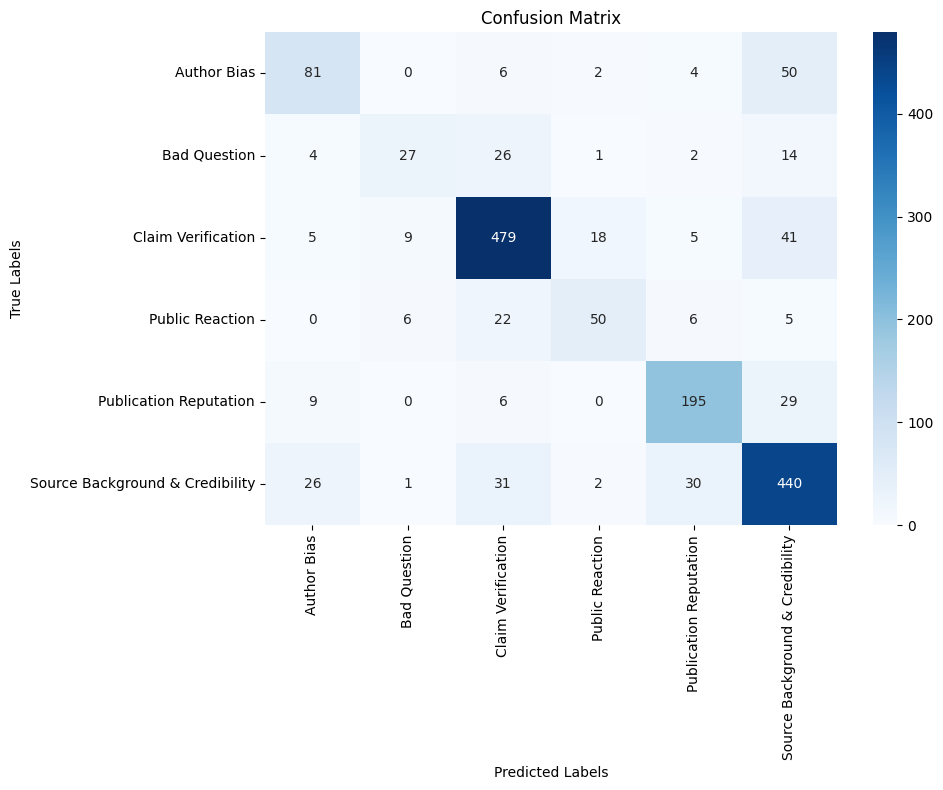

In [20]:
predictions = predict(Q_test_list, 64)
test_data_c = ["Author Bias", "Author Bias", "Author Bias", "Author Bias", "Author Bias",
               "Author Reputation", "Author Reputation", "Author Reputation", "Author Reputation", "Author Reputation",
               "Factual Query", "Factual Query", "Factual Query", "Factual Query", "Factual Query",
               "Publication Reputation", "Publication Reputation", "Publication Reputation", "Publication Reputation", "Publication Reputation"]
c_test = c_test.astype(str).tolist()
data_report(predictions, c_test)

Creates a Pandas dataFrame from the clueweb database

In [13]:
# Specify the path to the text file
file_path = 'trec-2024-lateral-reading-task2-baseline-documents.jsonl'


with open(file_path, 'r', encoding="utf8") as f:
    data = [json.loads(line) for line in f]

clue_df = pd.DataFrame(data)

print(len(clue_df))
clue_df.drop(columns=["URL-hash", "Language"], inplace=True)
clue_df.head()

38131


,URL,ClueWeb22-ID,Clean-Text
0,https://www.dailymail.co.uk/news/article-10130...,clueweb22-en0032-91-05114,"Japan's Princess Mako marries commoner, loses ..."
1,https://www.nytimes.com/2021/08/26/opinion/afg...,clueweb22-en0027-70-17775,Opinion | Let’s Not Pretend That the Way We Wi...
2,https://www.politicshome.com/thehouse/article/...,clueweb22-en0032-18-01494,No longer can China’s atrocities against the U...
3,https://medicaladvise.org/clinical-trials-rese...,clueweb22-en0012-53-13803,How does molnupiravir work? - Medical Advise\n...
4,https://www.euronews.com/2021/12/10/mexico-tru...,clueweb22-en0002-69-11564,Mexico truck crash: Dozens killed after lorry ...


Create FAISS index and save it to disk

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Good balance of speed/accuracy

# Your text database
texts = clue_df["Clean-Text"].tolist()

# Create embeddings
embeddings = model.encode(texts,batch_size=32, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

# Initialize FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Use IndexFlatIP with normalized vectors for cosine similarity

np.save("embedding_matrix.npy", embeddings)
# Add embeddings to index
index.add(embeddings)
faiss.write_index(index, "semantic_index.faiss")

Load FAISS index

In [15]:
index = faiss.read_index("semantic_index.faiss")

In [ ]:
vector = index.reconstruct(20)
query = "Newsweek Gets DESTROYED For Fearmongering on Kids & Vaccine"
query_embedding = model.encode(query, convert_to_numpy=True, normalize_embeddings=True).astype('float32')
query_embedding = np.expand_dims(query_embedding, axis=0)
scores, indices = index.search(query_embedding, 5)

count = 0

with open("trec-2024-lateral-reading-task2-baseline-documents.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if count == 19000:
            data = json.loads(line)
            print(data)  # do whatever with one object at a time
            break
        count += 1


{'URL': 'https://poorrichardsnews.com/ana-navarro-is-a-moron/\n', 'URL-hash': 'D06D4FDF2BF042D631B9C28D2A57C4D8', 'Language': 'en', 'ClueWeb22-ID': 'clueweb22-en0000-61-05623', 'Clean-Text': 'Ana Navarro is a moron – PoorRichardsNews.com\nAna Navarro is a moron\nHome /Illegal Aliens, International/Ana Navarro is a moron\nIllegal Aliens,International|\nOctober 23, 2019\nNavarro denies Venezuela’s Maduro is a socialist\nOn the view Ana Navarro cannot control her mouth.\nThe View remains such an awful example example of how moronic Hollywood and commentators are who don’t know the facts.\n“Maduro is NOT a socialist, he is a corrupt Murderer… blah, blah blah….”\nAnna Navarro files her nails on TV\nNavarro files her nails during border wall debate\nWatch on\n“Hypocrisy needs to be called out in American Politics, and the absurd has reached the point that it is insufferable”\n“Democrat Congressman Ted Lieu and CNN’s resident RINO Ana Navarro both fell for a hoax tweet posted by leftist Time 

Query the index

In [17]:
# Data prep
texts = clue_df["Clean-Text"].tolist()
IDs = clue_df["ClueWeb22-ID"].tolist()

# Query
query = "How does the glue gunner work in BloonsTD6?"
query_tag = "clueweb22-en0030-87-05450"
model = SentenceTransformer('all-MiniLM-L6-v2')
# Encode query
query_embedding = model.encode(query, convert_to_numpy=True, normalize_embeddings=True).astype('float32')
query_embedding = np.expand_dims(query_embedding, axis=0)  # shape (1, dim)

# Load FAISS index (assumed to be cosine similarity = inner product of normalized vectors)
index = faiss.read_index("semantic_index.faiss")

# Search
k = 10  # search more than 5 in case we exclude the query itself
scores, indices = index.search(query_embedding, k)

# Filter out the query itself and build results
results = []
for score, idx in zip(scores[0], indices[0]):
    if IDs[idx] == query_tag:
        continue  # skip the query origin

    text = texts[idx]
    snippet = text[:200].replace('\n', ' ')
    if len(text) > 200:
        snippet += '...'

    results.append({
        "rank": len(results) + 1,
        "score": round(float(score), 4),
        "snippet": snippet,
        "id": IDs[idx],
    })

    if len(results) == 5:
        break  # stop once we have top 5 (excluding query)

# Print results
for r in results:
    print(f"Rank: {r['rank']}, Score: {r['score']}, ID: {r['id']}, Snippet: {r['snippet']}")

Rank: 1, Score: 0.7362, ID: clueweb22-en0016-63-04220, Snippet: Super Glue | Bloons Wiki | Fandom Bloons Wiki 4,424 pages Explore Bloons Games Game Mechanics Other Pages Wiki-Related Info in: Glue Gunner, Bloons TD 6, Upgrades, and 5 more Super Glue Edit BTD6 BTDB...
Rank: 2, Score: 0.4847, ID: clueweb22-en0022-56-01572, Snippet: Shattering Shells | Bloons Wiki | Fandom Bloons Wiki 4,428 pages Explore Bloons Games Game Mechanics Other Pages Wiki-Related Info in: Articles in construction with a WIP, Mortar Monkey, Bloons TD 6, ...
Rank: 3, Score: 0.4604, ID: clueweb22-en0002-59-07035, Snippet: Sticky Bomb | Bloons Wiki | Fandom Bloons Wiki 4,428 pages Explore Bloons Games Game Mechanics Other Pages Wiki-Related Info in: Ninja Monkey, Bloons TD 6, Upgrades, and 4 more Sticky Bomb Edit BTD6 B...
Rank: 4, Score: 0.4592, ID: clueweb22-en0011-30-13287, Snippet: Fortified Bloon | Bloons Wiki | Fandom Bloons Wiki 4,434 Explore Bloons Games Game Mechanics Other Pages Wiki-Related Info in: Bloon

Load in marco database in batches into dataframe and save to disk

In [9]:
# Specify the path to the text file
file_path = 'msmarco_v2.1_doc_00.json'


with open(file_path, 'r', encoding="utf8") as f:
    data = [json.loads(line) for line in f]

ms_df = pd.DataFrame(data)
ms_df.drop(columns=["url", "title", "headings"], inplace=True)
print(len(ms_df))
ms_df.head()

193732


,body,docid
0,0-60 Times - 0-60 | 0 to 60 Times & 1/4 Mile T...,msmarco_v2.1_doc_00_0
1,Ethel Percy Andrus Gerontology Center [WorldCa...,msmarco_v2.1_doc_00_4810
2,Museo Nacional de Bellas Artes (Cuba) [WorldCa...,msmarco_v2.1_doc_00_18906
3,File extension 00000 is used by operating syst...,msmarco_v2.1_doc_00_32860
4,Open 00001 File\n\nOpen 00001 File\nTo open 00...,msmarco_v2.1_doc_00_37424


Code for vectorizing marcoDB

In [ ]:
json_input_dir = ""
output_dir = "output/"
model = SentenceTransformer('all-MiniLM-L6-v2')


# Specify the path to the text file
for entry in os.scandir(json_input_dir):
    if entry.is_file():  # check if it's a file
        print("Starting: ", entry.name)
        with open(entry, 'r', encoding="utf8") as f:
            data = [json.loads(line) for line in f]
        marco_df = pd.DataFrame(data)
        marco_df.drop(columns=["url", "title", "headings"], inplace=True)


        # Your text database
        texts = marco_df["body"].tolist()

        # Create embeddings
        embeddings = model.encode(texts,batch_size=200, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

        # Initialize FAISS index
        dimension = embeddings.shape[1]
        index = faiss.IndexFlatIP(dimension)  # Use IndexFlatIP with normalized vectors for cosine similarity

        # Add embeddings to index
        index.add(embeddings)
        faiss.write_index(index, "semantic_index_" + entry.name[17] + entry.name[18] + ".faiss")
        data.clear()